# **Semantic Segmentation of Ariel Images**

In [1]:
def setup_env():
    !pip install -q -U albumentations
    !echo "$(pip freeze | grep albumentations) is successfully installed"
    !pip install multiprocess
    !cp -r ../input/trainer/ ./
    
setup_env()

albumentations==1.0.3 is successfully installed


In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from operator import itemgetter
from multiprocess import Pool
from itertools import product
from datetime import datetime
import random
import csv

from tqdm.auto import tqdm

import cv2

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision.models as models

from trainer import Trainer, hooks
from trainer.utils import (
    setup_system,
    patch_configs  
)
from trainer.base_metric import BaseMetric
from trainer.configuration import SystemConfig, DatasetConfig, TrainerConfig, OptimizerConfig, DataloaderConfig
from trainer.matplotlib_visualizer import MatplotlibVisualizer

import matplotlib.pyplot as plt

In [7]:
# Dataset class implementation
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.
    
        Arguments:
            data_path (string): Path to the dataset folder.
            data_type (string): 'train', 'val' or 'test'
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transforms that inputs a sample image
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
    """
    
    def __init__(self, data_path, data_type, num_classes=12, transforms=None, 
                 class_names=["Background", "Person", "Bike", "Car", "Drone", "Boat", "Animal", "Obstacle", "Construction", "Vegetation", "Road", "Sky"], 
                 **kwargs):
        
        super().__init__(**kwargs)
        random.seed(20)
        self.num_classes = num_classes
        self.transforms = transforms
        self.class_names = class_names
        self.data_type = data_type
        
        data_array = []        
        csv_path = os.path.join(data_path, "test.csv") if (self.data_type == 'test') else os.path.join(data_path, "train.csv")
        
        def lambda_transform(x):
            x = x.strip()
            if (self.data_type == 'test'):
                return (
                    os.path.join(data_path, "imgs", "imgs", (x + ".jpg")), 
                )
            else:
                return (
                    os.path.join(data_path, "imgs", "imgs", (x + ".jpg")), 
                    os.path.join(data_path, "masks", "masks", (x + ".png"))
                )
        
        with open(csv_path, 'r') as f:
            f.readline()
            data_array = list(map(lambda_transform, f.readlines()))
            
        samples = random.sample(data_array, len(data_array))
        
        if (self.data_type == 'test'):
            self.dataset = samples
        else:
            split_index = round(0.95 * len(data_array))
            split_index = (split_index + 1) if split_index % 2 != 0 else split_index 
            self.dataset = samples[:split_index] if (self.data_type == 'train') else samples[split_index:]
        
        self.dataset = np.array(self.dataset)
            
            
    def __len__(self): 
        return len(self.dataset)
    
        
    def __getitem__(self, idx):
        
        random.seed(datetime.now())
        if (self.data_type == 'test'):
            sample = {
                "image": cv2.imread(self.dataset[idx][0])[..., ::-1],
                "filename": os.path.basename(self.dataset[idx][0]).split('.')[0]
            }
        else:
            sample = {
                "image": cv2.imread(self.dataset[idx][0])[..., ::-1],
                "mask": cv2.imread(self.dataset[idx][1], cv2.IMREAD_UNCHANGED),
                "filename": os.path.basename(self.dataset[idx][0]).split('.')[0]
            }
        
        if self.transforms is not None:
            sample = self.transforms(**sample)
            if self.data_type != "test":
                sample["mask"] = sample["mask"].long()
        return sample
    
    def get_num_classes(self):
        return self.num_classes
    
    def get_class_name(self, idx):
        class_name = ""
        if self.class_names is not None and idx < len(self.num_classes):
            class_name = self.class_names[idx]
        return class_name

In [8]:
class_color_map = {
    0: (13, 25, 38), # background
    1: (84, 57, 172), # Person
    2: (191, 140, 217), # Bike
    3: (193, 111, 68), # Car
    4: (28, 34, 84), # Drone
    5: (84, 28, 53), # Boat
    6: (56, 142, 168), # Animal
    7: (92, 96, 32), # Obstale
    8: (144, 218, 161), # Construction
    9: (31, 92, 79), # Vegetation
    10: (153, 51, 141), # Road
    11: (140, 187, 217) # Sky
}

class_names=["Background", "Person", "Bike", "Car", "Drone", "Boat", "Animal", "Obstacle", "Construction", "Vegetation", "Road", "Sky"]


In [9]:
def decode_segmap(mask, class_color_map):
    mask = mask.squeeze()
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
  
    for l in range(len(class_color_map)):
        idx = mask == l
        r[idx] = class_color_map[l][0]
        g[idx] = class_color_map[l][1]
        b[idx] = class_color_map[l][2]
    
    rgb = np.stack([r, g, b], axis=2)
    
    return rgb

# Visualize Dataset

In [20]:
def visualize_segmentation_dataset(dataset, num_sample, class_color_map):
    r_idx = torch.randperm(len(dataset))[:num_sample]

    fig, axs = plt.subplots(num_sample, 2, constrained_layout=True, figsize=(24,num_sample*8))
    fig.suptitle("Random samples")
    for i, idx in enumerate(r_idx):

        idx = idx
        sample = dataset[idx]
        axs[i, 0].imshow(sample["image"])
        axs[i, 0].axis('off')
        axs[i, 0].set_title('image')
        axs[i, 1].imshow(decode_segmap(sample["mask"], class_color_map))
        axs[i, 1].set_title('mask')
        axs[i, 1].axis('off')
        
        

In [17]:
train_dataset = SemSegDataset("../input/segmentationopencv/", "train")

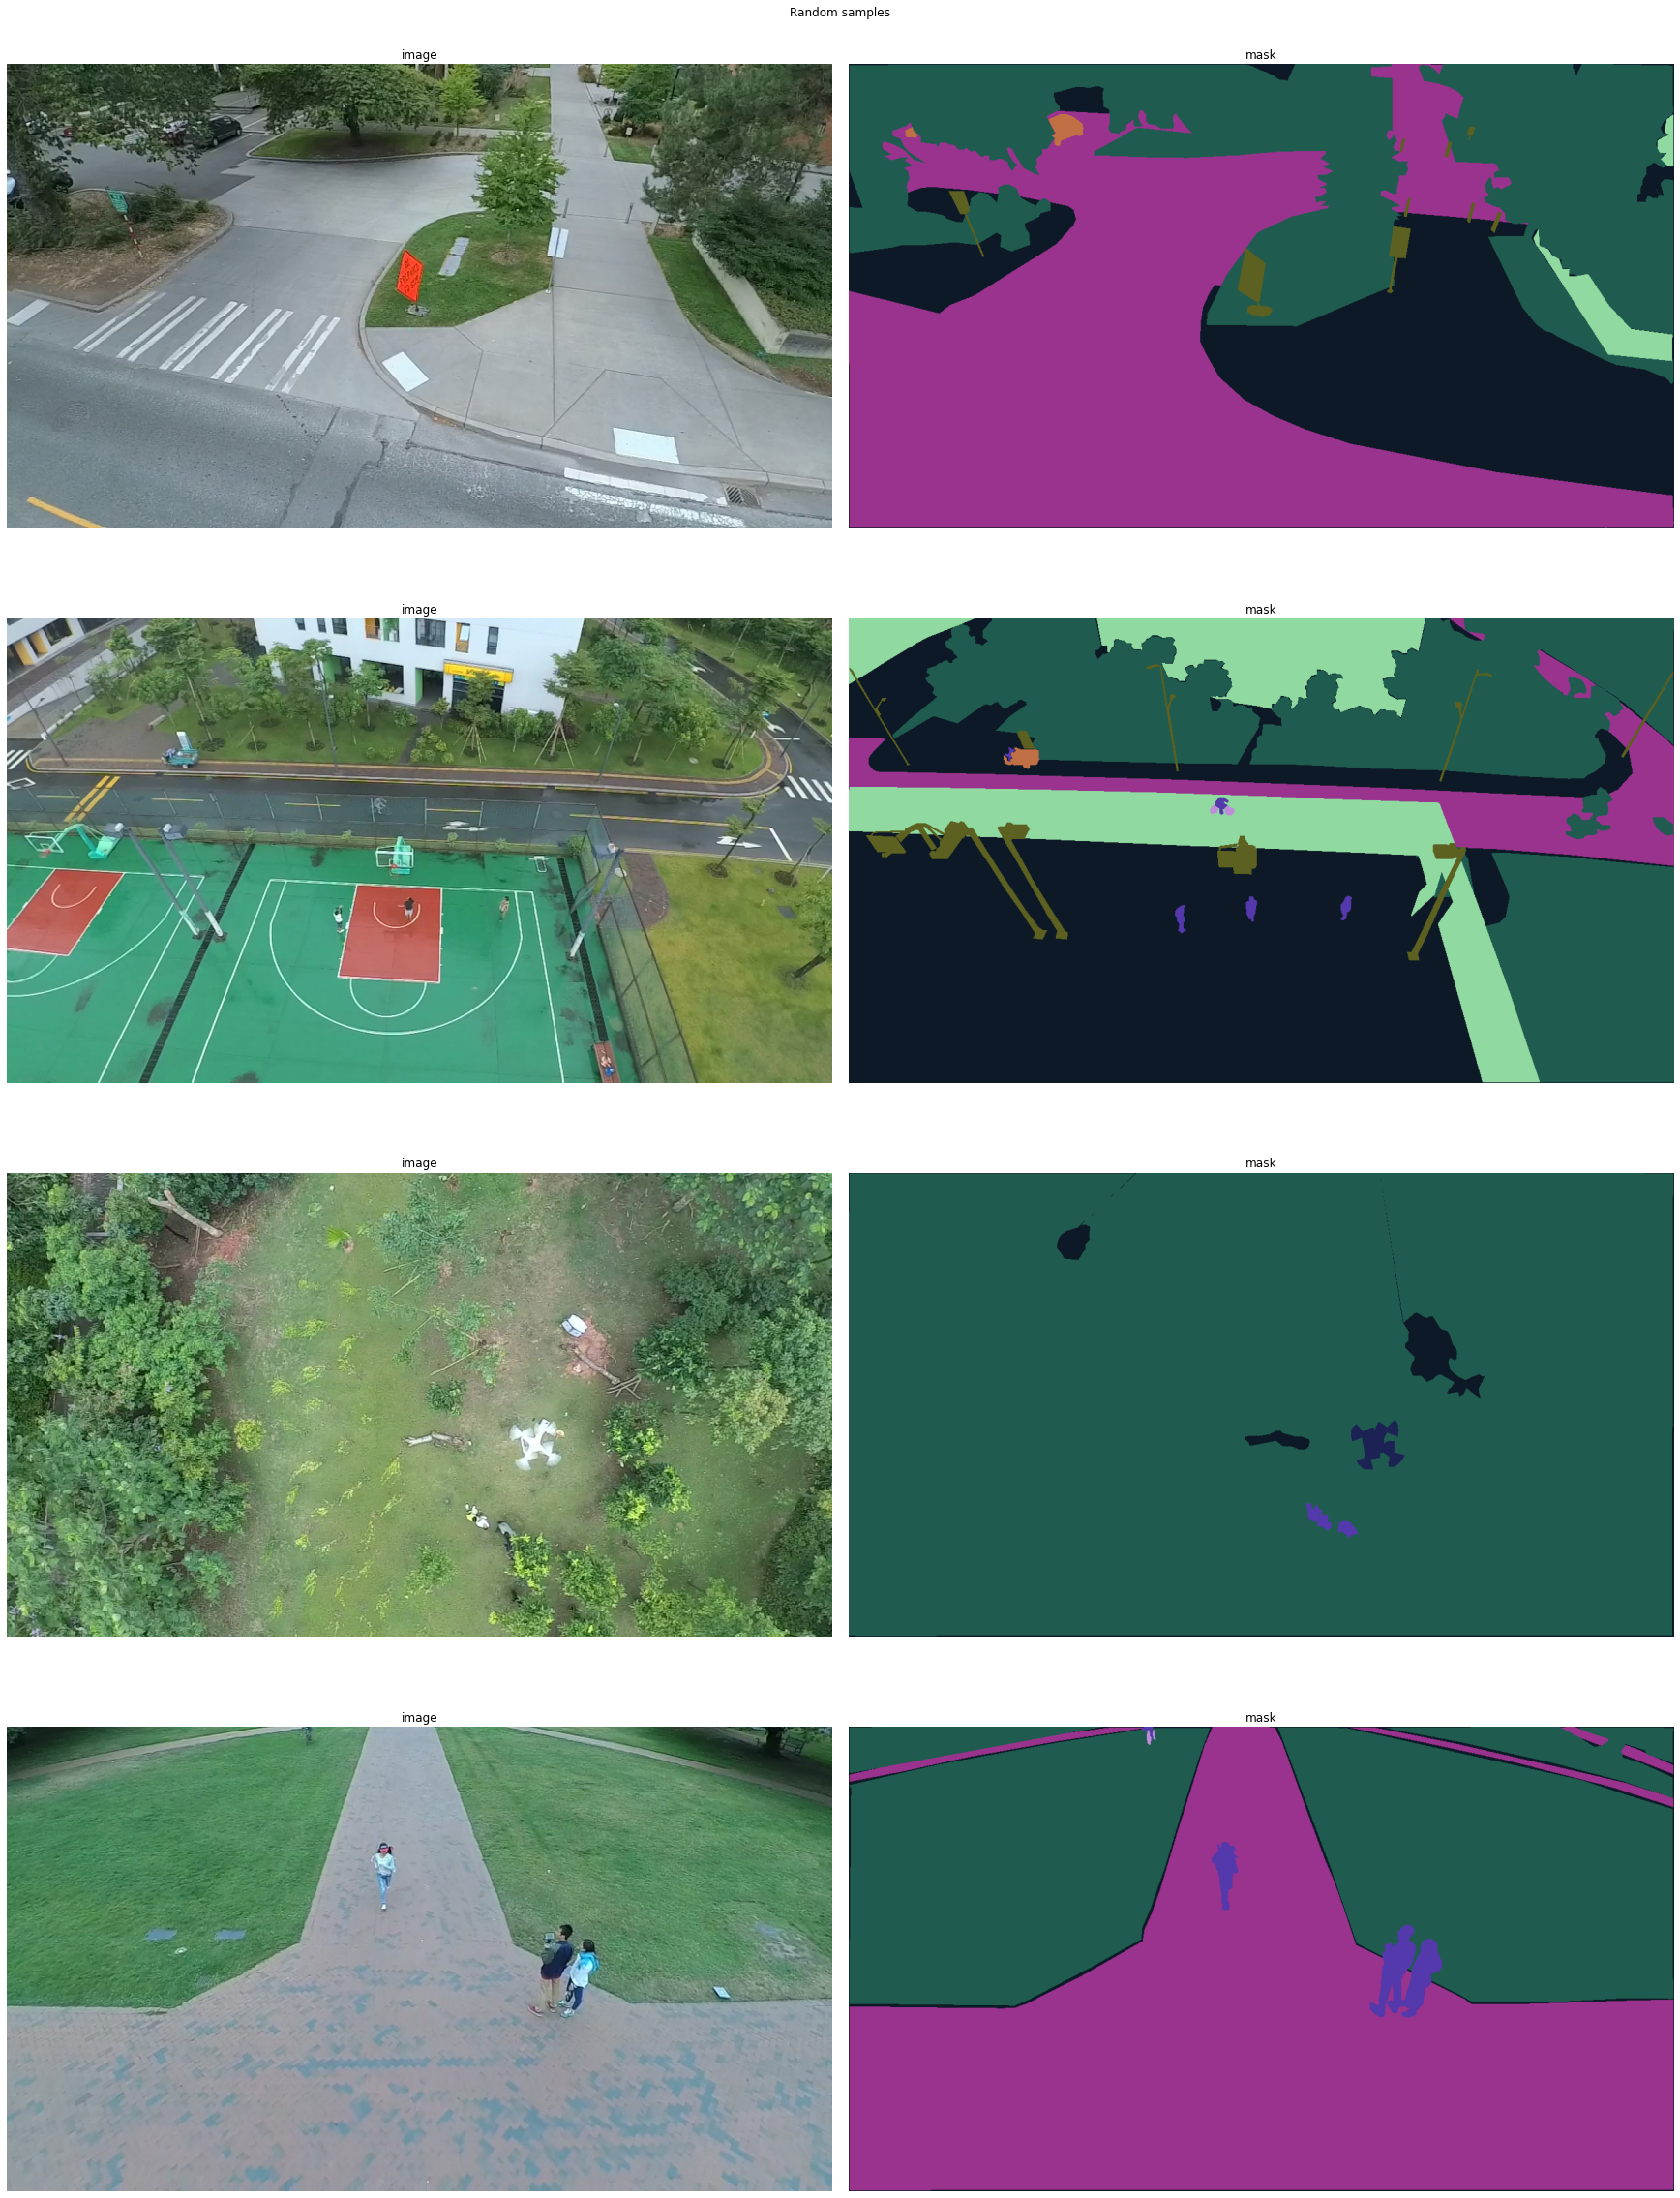

In [19]:
visualize_segmentation_dataset(train_dataset, 4, class_color_map)

# Evaluation Metrics

In [ ]:
# create confusion matrix class

class ConfusionMatrix(BaseMetric):
    """
        Implementation of Confusion Matrix.

        Arguments:
            num_classes (int): number of evaluated classes.
            normalized (bool): if normalized is True then confusion matrix will be normalized.
    """
    def __init__(self, num_classes, normalized=False):
        # init confusion matrix class fields
        self.num_classes = num_classes
        self.normalized = normalized
        self.conf = np.ndarray((num_classes, num_classes), np.int32)
        self.reset()
        
    def reset(self):
        """
            Reset of the Confusion Matrix.
        """
        self.conf.fill(0)
        
    def update_value(self, pred, target):
        """
            Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if torch.is_tensor(pred):
            # convert the prediction tensor to numpy array
            pred = pred.detach().cpu().numpy()
        if torch.is_tensor(target):
            # convert the target tensor to numpy array
            target = target.detach().cpu().numpy()

        # get rid of invalid indices
        valid_indices = np.where((target >= 0) & (target < self.num_classes))
        pred = pred[valid_indices]
        target = target[valid_indices]

        # calculate confusion matrix value for new predictions
        replace_indices = np.vstack((target.flatten(), pred.flatten())).T
        conf, _ = np.histogramdd(
            replace_indices,
            bins=(self.num_classes, self.num_classes),
            range=[(0, self.num_classes), (0, self.num_classes)]
        )
        # update confusion matrix value
        self.conf += conf.astype(np.int32)
        
    def get_metric_value(self):
        """
            Return the Confusion Matrix.

            Returns:
                numpy.ndarray(num_classes, num_classes): confusion matrix.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            # get normalized confusion matrix
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        return self.conf


In [ ]:
# create DiceCoefficient class
class DiceCoefficient(BaseMetric):
    """
        Implementation of the Dice coefficient metric.

        Arguments:
            num_classes (int): number of evaluated classes.
            reduced_probs (bool): if True, then argmax was applied to the input predictions.
            normalized (bool): if normalized is True, then confusion matrix will be normalized.
            ignore_indices (int or iterable): list of ignored classes indices.
    """
    def __init__(self, num_classes, reduced_probs=False, normalized=False, ignore_indices=None):
        # created a normalized confusion matrix with num_classes
        self.conf_matrix = ConfusionMatrix(num_classes=num_classes, normalized=normalized)
        self.reduced_probs = reduced_probs

        # check whether ignored classes exist
        if ignore_indices is None:
            self.ignore_indices = None
        elif isinstance(ignore_indices, int):
            self.ignore_indices = (ignore_indices, )
        else:
            try:
                self.ignore_indices = tuple(ignore_indices)
            except TypeError:
                raise ValueError("'ignore_indices' must be an int or iterable")

    def reset(self):
        """
            Reset the Confusion Matrix
        """
        self.conf_matrix.reset()

    def update_value(self, pred, target):
        """ Add sample to the Confusion Matrix.

            Arguments:
                pred (torch.Tensor() or numpy.ndarray): predicted mask.
                target (torch.Tensor() or numpy.ndarray): ground-truth mask.
        """
        if not self.reduced_probs:
            pred = pred.argmax(dim=1)
        self.conf_matrix.update_value(pred, target)

    def get_metric_value(self):
        """ Return of the mean Dice and Dice per class.

        Returns:
            mean_dice (float32): mean dice.
            dice (list): list of dice coefficients per class.
        """
        # get confusion matrix value
        conf_matrix = self.conf_matrix.get_metric_value()

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # set column values of ignore classes to 0
            conf_matrix[:, self.ignore_indices] = 0
            # set row values of ignore classes to 0
            conf_matrix[self.ignore_indices, :] = 0

        # get TP, FP and FN values
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # use errstate to handle the case of zero denominator value
        with np.errstate(divide='ignore', invalid='ignore'):
            # calculate iou by its formula
            dice = 2 * true_positive / (2 * true_positive + false_positive + false_negative)

        # check whether the list of indices to ignore is empty
        if self.ignore_indices is not None:
            # exclude ignore indices
            dice_valid_cls = np.delete(dice, self.ignore_indices)
            # get mean class iou value ignoring NaN values
            mdice = np.nanmean(dice_valid_cls)
        else:
            # get mean class iou value ignoring NaN values
            mdice = np.nanmean(dice)
        return {"mean_dice": mdice, "dice": dice}

# Model

In [ ]:
class SemanticSegmentation(nn.Module):
    """
        Implementation of Model used for segmentation
        
        Arguements:
            num_classes (int): number of class
    """
    
    def __init__(self, num_classes):
        
        super().__init__()
        
        self.seg_model = models.segmentation.deeplabv3_resnet101(pretrained=True)
        
        self.seg_model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        
    def forward(self, x):
        
        return self.seg_model(x)

# Train & Inference



### Loss Function

In [21]:
#  soft-dice loss
class SoftDiceLoss(nn.Module):
    """
        Implementation of the Soft-Dice Loss function.

        Arguments:
            num_classes (int): number of classes.
            eps (float): value of the floating point epsilon.
    """
    def __init__(self, num_classes, eps=1e-5):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.eps = eps

    #  forward pass
    def forward(self, pred_logits, targets):
        """
            Compute Soft-Dice Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W). targets (torch.LongTensor): tensor of ground-truth labels. 
                The shape of the tensor is (B, H, W).
        """
        # get predictions from logits
        preds = pred_logits.softmax(dim=1)
        loss = 0
        # iterate over all classes
        for cls in range(self.num_classes):
            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection of predictions and targets
            intersection = (pred * target).sum()

            # compute dice
            dice = (2 * intersection + self.eps) / (pred.sum() + target.sum() + self.eps)

            # compute negative logarithm from the obtained dice coefficient
            loss = loss - dice.log()

        # get mean loss by class value
        loss = loss / self.num_classes

        return loss

In [ ]:
#  Focal loss
class FocalLoss(nn.Module):
    """
        Implementation of the Focal Loss function.

        Arguments:
            num_classes (int): number of classes.
                valid_labels: 0,..., num_classes - 1
                ignore_index: num_classes
            gamma (float): parameter which control slope of loss function.
    """
    def __init__(self, num_classes, gamma=2.0, ignore_indices=-1):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.gamma = gamma
        self.loss_fn = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_indices)

    #  forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W).
                targets (torch.LongTensor): tensor of ground-truth labels. The shape of the tensor is 
                (B, H, W).
        """
        loss_ce = self.loss_fn(pred_logits, target)
        loss_focal = (1.0 - loss_ce.mul(-1).exp()).pow(self.gamma) * loss_ce
        return loss_focal.mean()

In [ ]:
#  semantic segmentation loss
class SemanticSegmentationLoss(nn.Module):
    """
        Implementation of the multi-objective loss function for semantic segmentation.

        Arguments:
            num_classes (int): number of classes.
            dice_alpha (float): weight of the SoftJaccardLoss
    """
    def __init__(self, num_classes, dice_alpha=0.1, ignore_indices=-1):
        super().__init__()
        # init fields
        self.dice_alpha = dice_alpha
        self.dice = SoftDiceLoss(num_classes)
        self.focal = FocalLoss(num_classes=num_classes, ignore_indices=ignore_indices)

    #  forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W). targets (torch.LongTensor): tensor of ground-truth labels. 
                The shape of the tensor is (B, H, W).
        """
        # our loss is a weighted sum of two losses
        dice_loss = self.dice_alpha * self.dice(pred_logits, target)
        focal_loss = self.focal(pred_logits, target)
        loss = dice_loss + focal_loss
        return loss

### Data Augmentation

In [ ]:
train_transform = A.Compose(
    [
        A.OneOf(
            [
                A.ShiftScaleRotate(),
                A.Affine(mode=4),
                A.Perspective(pad_mode=4, interpolation=2)
            ], p=.75
        ),
        A.RandomCrop(512,512),
        A.HorizontalFlip(),
        A.OneOf(
            [
                A.CLAHE(),
                A.RGBShift(),
                A.RandomBrightnessContrast(),
                A.RandomGamma(),
                A.HueSaturationValue(),
            ], p=.75
        ),
        A.Normalize(),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)

In [ ]:
# experiment class
class Experiment:
    def __init__(
        self,
        # init configs
        system_config: SystemConfig = SystemConfig(cudnn_benchmark_enabled=False),
        dataset_config: DatasetConfig = DatasetConfig(),
        dataloader_config: DataloaderConfig = DataloaderConfig(),
        optimizer_config: OptimizerConfig = OptimizerConfig(),
    ):
        # apply system settings
        self.system_config = system_config
        setup_system(system_config)
        #  train dataloader
        self.loader_train = DataLoader(
            #  our dataset
            SemSegDataset(
                data_path = "../input/segmentationopencv/",
                data_type = "train",
                transforms = train_transform
            ),
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            pin_memory=False
        )

        #  test dataloader
        self.loader_test = DataLoader(
            SemSegDataset(
                data_path = "../input/segmentationopencv/",
                data_type = "val",
                transforms = val_transform
            ),
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            pin_memory=False
        )

        #  model
        self.model = SemanticSegmentation(
            num_classes=12
        )
        
        
        #  loss function as custom loss
        self.loss_fn = SemanticSegmentationLoss(12)
        #  metrics function as dice score
        self.metric_fn = DiceCoefficient(
            num_classes=12, reduced_probs=False
        )
        #  optimizer and its params
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            #weight_decay=optimizer_config.weight_decay
        )
#          learning rate scheduler
#         self.lr_scheduler = MultiStepLR(
#             self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=0.3
#         )
        self.lr_scheduler = ReduceLROnPlateau(self.optimizer, patience=1, factor=0.3)
        #  visualizer
        self.visualizer = None
        self.epoch = -1
        resume = True
        if resume:
            device = torch.device(trainer_config.device)
            self.model = self.model.to(device)
            checkpoint = torch.load('./checkpoints/SemanticSegmentation_best.pth')
            self.epoch = checkpoint['epoch']
            self.model.load_state_dict(checkpoint['model_state_dict'])#, map_location=device)
#             self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])#, map_location=device)
#             self.lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])#, map_location=device)
#             print(self.model.device(), self.optimizer.device(), self.lr_scheduler.device())
            
    # run training
    def run(self, trainer_config: TrainerConfig) -> dict:
        # apply system settings
        setup_system(self.system_config)
        # move training to the chosen device
        device = torch.device(trainer_config.device)
        # send data to chosen device
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        #  trainer
        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("mask"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mean_dice"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir,
            current_epoch = self.epoch,
            unfreeze_epoch = 300,
            unfreeze_layer = [72, 900, 1200, 1500, 1800]
        )

        #  hook to run after each epoch
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_semseg)
        # run the training
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

In [ ]:
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=120, batch_size_to_set=16)


optimizer_config = OptimizerConfig(learning_rate=3e-5, lr_step_milestones =[15,20], weight_decay=0.1)
experiment = Experiment(dataloader_config=dataloader_config, optimizer_config=optimizer_config)


In [ ]:
torch.cuda.empty_cache()
metrics = experiment.run(trainer_config)

In [ ]:
def denormailze(img):
    return np.uint8(A.Normalize(mean=(-0.485/0.229, -0.456/0.224, -0.406/0.225), 
               std=(1/(0.229*255), 1/(0.224*255), 1/(0.225*255)),
               max_pixel_value=1.)(image=img)['image'])

In [ ]:
def visualize_segmentation_pred(images, 
                                mask, 
                                pred, class_color_map):
    fig, axs = plt.subplots(len(images), 3, constrained_layout=True, figsize=(18,4*len(images)))
    fig.suptitle("Preds")
    for i in range(len(images)):
        axs[i, 0].imshow(denormailze(np.transpose(images[i].numpy(), (1,2,0))))
        axs[i, 0].axis('off')
        axs[i, 0].set_title('image')
        axs[i, 1].imshow(decode_segmap(mask[i], class_color_map))
        axs[i, 1].set_title('mask')
        axs[i, 1].axis('off')
        axs[i, 2].imshow(decode_segmap(pred[i], class_color_map))
        axs[i, 2].set_title('pred')
        axs[i, 2].axis('off')
        
        

In [ ]:
torch.cuda.empty_cache()
model = SemanticSegmentation(12)
model.to('cuda')
checkpoint = torch.load('./checkpoints/SemanticSegmentation_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
val_dataset = SemSegDataset('../input/segmentationopencv/', 'val', transforms=val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 8, False)
d = iter(val_dataloader)

In [ ]:
torch.cuda.empty_cache()
submission = []
sample = next(d, None)
model.to('cuda')
model.eval()
num = 0
while sample is not None and num<1:
    print(num)
    num += 1
    sample_img = sample['image'].to('cuda')
    with torch.no_grad():
        preds = model(sample_img)['out'].softmax(dim=1).argmax(dim=1).to('cpu').detach().numpy()
    visualize_segmentation_pred(sample_img.to('cpu').detach(), 
                                sample["mask"].detach().numpy(), 
                                preds,
                                class_color_map)
    torch.cuda.empty_cache()
    sample = next(d, None)

In [ ]:
def mask2rle(mask): 
    num_classes = 12
    rle = [" " for x in range(num_classes)]

    mask_classes = np.unique(mask)

    for clx in mask_classes:
        mask_clx = (mask == clx).astype(np.uint8)
        pixels = mask_clx[:,:].flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        rle[clx] = ' '.join(str(x) for x in runs)

    return rle

In [ ]:
test_transform = val_transform

In [ ]:
test_dataset = SemSegDataset('../input/segmentationopencv/', 'test', transforms=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 16, False, num_workers=os.cpu_count(),)
d = iter(test_dataloader)

In [ ]:
torch.cuda.empty_cache()
submission = []
sample = next(d, None)
model.to('cuda')
model.eval()
num = 0
while sample is not None:
    num += 1
    sample_img = sample['image'].to('cuda')
    with torch.no_grad():
        preds = model(sample_img)['out'].softmax(dim=1).argmax(dim=1).to('cpu').detach().numpy()
    with Pool(os.cpu_count()) as p:
        enc = p.map(mask2rle, preds)
    print(num)
    submission = submission + list(zip(sample['filename'], enc))
    torch.cuda.empty_cache()
    sample = next(d, None)

In [ ]:
with open('names_deeplabv3_101.csv', 'w') as csvfile:
    fieldnames = ['ImageID', 'EncodedPixels']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for k, v in submission:
        for idx, enc in enumerate(v):
            writer.writerow({'ImageID': k + '_' + str(idx), 'EncodedPixels': enc.strip()})

In [ ]:
!cp ../input/kaggle-api-json/kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions submit -c opencv-pytorch-course-segmentation -f names_deeplabv3_101.csv -m ""